## experiment with setting up a preprocessing pipeline
https://keras.io/preprocessing/image/
## read nvidia paper
http://images.nvidia.com/content/tegra/automotive/images/2016/solutions/pdf/end-to-end-dl-using-px.pdf

## Todo:
1. Remove steering 0 bias from data frame
2. Implement get_preprocessed_image which grabs a random image from the dataframe. 50% of the time use Keras image generator to manipulate the image.
    * adjust steering angle for left (+.25) and right images (-.25)
    * crop image[32:132]
    * convert to RGB
    * resize to 64 x 64
3. Split dataframe into X_train, y_train, X_valid, y_valid
    * use train_test_split 10% validation
4. Use keras generator with rotation_range=5 and maybe some other shifts
    1. samples_per_epoch=len(X_train)
    2. batch_size=32
    3. nb_epoch=1
5. Explore values manually
6. Save model and weights

In [57]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import random
import pandas as pd
import numpy as np
import cv2
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline


DATA_PATH = '../data/'


def remove_zero_bias(df):
    rows_with_steering_zero = df[(df.steering == 0)]
    total_rows_with_steering_zero = len(rows_with_steering_zero)
    drop_indices = np.random.choice(rows_with_steering_zero.index, int(total_rows_with_steering_zero * 0.90), replace=False)
    
    return df.drop(drop_indices)


def augment_steering_angles_and_reshape_dataframe(df):
    rows = []
    
    for _, row in df.iterrows():
        rows.append({ 'image': row.left, 'steering': row.steering + .25, 'is_flipped': False })
        rows.append({ 'image': row.center, 'steering': row.steering, 'is_flipped': False })
        rows.append({ 'image': row.right, 'steering': row.steering - .25, 'is_flipped': False })
        
    return pd.DataFrame(rows)


def augment_with_horizontal_flip(df):
    df_flipped = df.copy()
    df_flipped.steering = df_flipped.steering.apply(lambda x: x * -1)
    df_flipped.is_flipped = True
    
    return pd.concat([df, df_flipped])

    
def augment_dataframe(df):
    df = remove_zero_bias(df)
    df = augment_steering_angles_and_reshape_dataframe(df)
    df = augment_with_horizontal_flip(df)
    
    return df


def load_image(image_path, steering, is_flipped):
    image = cv2.imread(image_path)
    image = image[32:132]
    
    return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

,image,is_flipped,steering
0,IMG/left_2016_12_01_13_31_12_937.jpg,False,0.25
1,IMG/center_2016_12_01_13_31_12_937.jpg,False,0.00
2,IMG/right_2016_12_01_13_31_12_937.jpg,False,-0.25
3,IMG/left_2016_12_01_13_31_13_786.jpg,False,0.25
4,IMG/center_2016_12_01_13_31_13_786.jpg,False,0.00


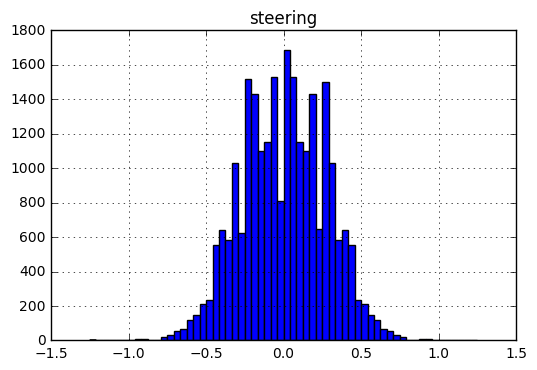

In [58]:
df = augment_dataframe(pd.read_csv('../data/' + 'driving_log.csv'))
df.hist(column='steering', bins=60)
df.head()

In [59]:
len(df)
df.tail()

,image,is_flipped,steering
12331,IMG/center_2016_12_01_13_46_38_090.jpg,True,-0.00
12332,IMG/right_2016_12_01_13_46_38_090.jpg,True,0.25
12333,IMG/left_2016_12_01_13_46_38_599.jpg,True,-0.25
12334,IMG/center_2016_12_01_13_46_38_599.jpg,True,-0.00
12335,IMG/right_2016_12_01_13_46_38_599.jpg,True,0.25


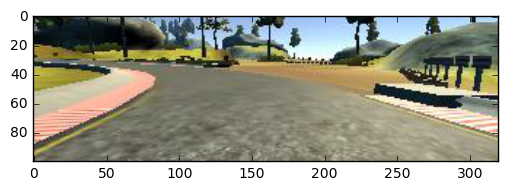

In [60]:
row = df.iloc[0]
image_path = DATA_PATH + row.image.strip()
plt.imshow(load_image(image_path, row.steering, row.is_flipped))